In [160]:
# Import libraries

import nltk
import re
import os
import time
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import warnings
from collections import OrderedDict
sentdetector = nltk.data.load('tokenizers/punkt/english.pickle')

In [152]:
# Regex for family members

familynames = re.compile(r'\b(mother|brother|grandfather|sister|grandmother|father|mom|dad|son|daughter|uncle|aunt|niece|nephew|cousin)(\'s|s)*\b', re.I)


In [153]:
# Read the txt files containing medical transcripts

def read_text_file(file_path):
    
    familysentences =[]
    text = open(file_path, encoding="utf8", errors='ignore').read()
    
    # tokenize the sentences     
    sentences = sentdetector.tokenize(text.strip(), realign_boundaries=True)
    
    # Get only those sentences with family members and 
    # remove white space characters, numbers and special symbols    
    for sent in sentences:
        if familynames.search(sent) is not None:
            sent = re.sub(r"[\n\t]*", "", sent)
            sent = re.sub(r'[^\w\s]', '', sent)
            sent = re.sub(r'[\d+]', '', sent)
            familysentences.append(sent.lower())

    return familysentences    

In [154]:
# Remove stop words from the tokenized sentences

def remove_stop_words(token_data):
    filtered_sentences = []
    for sentence in token_data:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(sentence)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        filtered_sentence = []
    
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)
                
        filtered_sentences.append(filtered_sentence)
    return filtered_sentences


In [155]:
# 3.1 and 3.2

# Get path. My file path is currently set. 

path = os.getcwd()
# os.chdir('./data')
# print(path)


files = []
token_data = []
filtered_data = []

for file in os.listdir():
    # Check whether file is in text format or not
    if file.endswith(".txt"):
        file_path = f"{path}//{file}"

        # Read the text file data        
        file_data = read_text_file(file_path)
        new = ' '.join(file_data)

        if (len(file_data) != 0):
            token_data.append(new)

# Remove stop words from the data read from text file
filtered_data = remove_stop_words(token_data)
print(len(filtered_data), filtered_data)
    

318 [['reports', 'family', 'history', 'glaucoma', 'mother', 'unsure', 'specific', 'kind'], ['seven', 'years', 'old', 'raised', 'mother', 'stepfather', 'sustain', 'relationship', 'biological', 'father', 'time', 'son', 'currently', 'years', 'old', 'home', 'maker', 'mr', 'worked', 'mother', 'restaurant', 'moved', 'work', 'borgwarner', 'corporation', 'one', 'two', 'years', 'beginning', 'plum', 'industries', 'worked', 'years', 'worked', 'way', 'lead', 'engineer'], ['date', 'motor', 'vehicle', 'accident', 'sitting', 'right', 'front', 'passengers', 'seat', 'wearing', 'seat', 'shoulder', 'belt', 'safety', 'harnesses', 'volvo', 'wagon', 'automobile', 'driven', 'son', 'family', 'history', 'reports', 'father', 'angina', 'mother', 'eosinophilia', 'brothers', 'sisters'], ['mother', 'wellchild', 'check', 'mother', 'states', 'well', 'regard', 'asthma', 'allergies'], ['babys', 'father', 'present', 'delivery', 'one', 'patients', 'sisters'], ['family', 'medical', 'history', 'patients', 'mother', 'histor

In [55]:
# 3.3

# Calculate minimum threshold. Since we want to have identify all the word associations 
# that occur in at least 5 sentences. 

min_support_threshold = round((5/len(filtered_data)), 2)
print(min_support_threshold)


0.02


In [56]:
# Convert data into dataframes, with the words as columns. 

te = TransactionEncoder()
te_ary = te.fit(filtered_data).transform(filtered_data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,abc,abcd,abcds,abcs,abdominal,able,abuse,abused,accident,accidentally,...,years,yeast,yet,yogurt,york,young,younger,yr,zyprexa,zyrtec
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
314,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
315,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
316,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
# Using mlxtend, apply the apriori function

itemsets = apriori(df, min_support= min_support_threshold, use_colnames=True)

In [58]:
# Get the association rules. 

rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [59]:
# Sort the rules in descending order of lift. 

rules.sort_values("lift", ascending = False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
410,(ear),(complaining),0.022013,0.022013,0.022013,1.000000,45.428571,0.021528,inf
57091,"(patient, sample, sister, family)","(history, transcription)",0.022013,0.022013,0.022013,1.000000,45.428571,0.021528,inf
49801,"(time, family)","(patient, age, mother, years)",0.022013,0.022013,0.022013,1.000000,45.428571,0.021528,inf
49800,"(patient, age, years)","(time, family, mother)",0.022013,0.022013,0.022013,1.000000,45.428571,0.021528,inf
42811,"(patient, sister, family, mother)",(year),0.022013,0.022013,0.022013,1.000000,45.428571,0.021528,inf
...,...,...,...,...,...,...,...,...,...
941,(son),(history),0.084906,0.449686,0.022013,0.259259,0.576535,-0.016168,0.742925
4903,(patient),"(died, father)",0.198113,0.194969,0.022013,0.111111,0.569892,-0.016613,0.905660
4902,"(died, father)",(patient),0.194969,0.198113,0.022013,0.112903,0.569892,-0.016613,0.903945
1145,(mother),(son),0.556604,0.084906,0.025157,0.045198,0.532329,-0.022102,0.958412


In [60]:
rules.shape

(62558, 9)

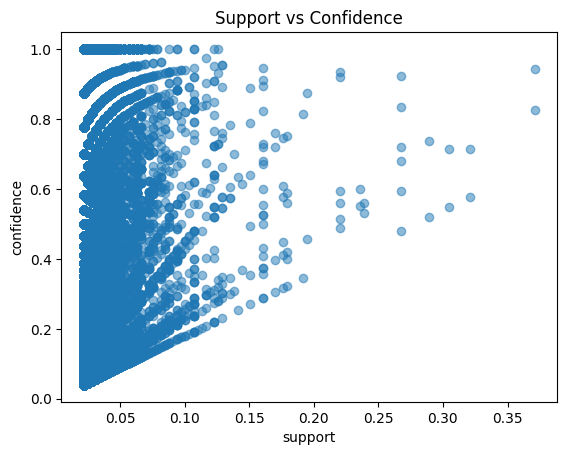

In [156]:
# Visualizing the results: 

# Support vs Confidence

plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

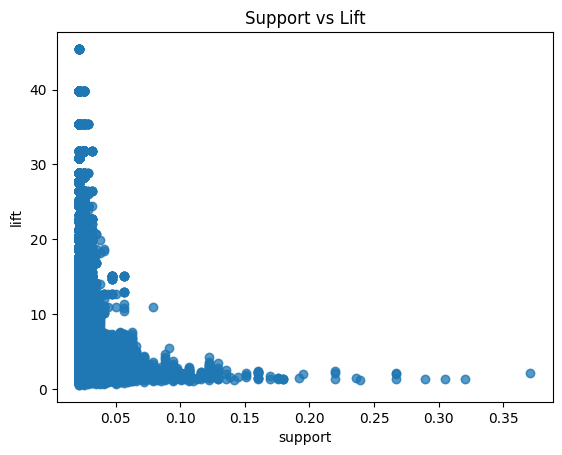

In [158]:
# Support vs Lift 

plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

Text(0.5, 1.0, 'Lift vs Confidence')

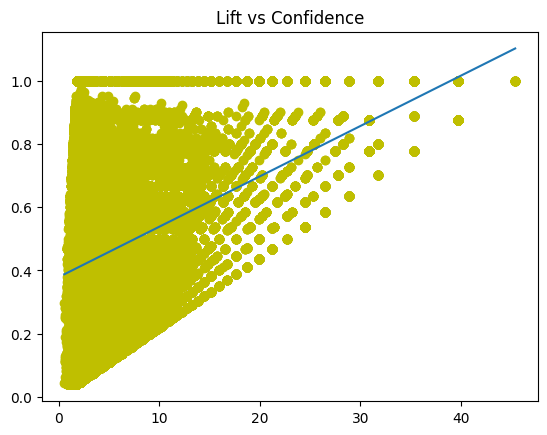

In [162]:
# Lift vs Confidence

fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))
plt.title('Lift vs Confidence')


In [61]:
# Filter the rules with respect to lift and confidence.

rec_rules = rules[ (rules['lift'] > 1) & (rules['confidence'] >= 0.5) ]

In [163]:
# Remove columns that are not needed, like antecedent support, consequent support, leverage and conviction.

cols_keep = {'antecedents':'item_1', 'consequents':'item_2', 'support':'support', 'confidence':'confidence', 'lift':'lift'}
cols_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']

word_associations = pd.DataFrame(rec_rules).rename(columns= cols_keep).drop(columns=cols_drop).sort_values(by=['support'], ascending = False)

display(word_associations)


,item_1,item_2,support,confidence,lift
657,(family),(history),0.371069,0.944000,2.099245
656,(history),(family),0.371069,0.825175,2.099245
902,(history),(mother),0.320755,0.713287,1.281498
903,(mother),(history),0.320755,0.576271,1.281498
767,(mother),(father),0.305031,0.548023,1.281406
...,...,...,...,...,...
58815,"(patient, history, family, lives)","(age, mother, brother)",0.022013,0.700000,7.420000
46998,"(patient, lives, family)","(age, mother, brother)",0.022013,0.700000,7.420000
49843,"(heart, two, mother)","(history, age, father)",0.022013,0.700000,7.420000
26173,"(fhx, father, brother)","(age, died)",0.022013,1.000000,7.395349


In [164]:
# Get antecedents and consequents as a list
antecedents = []
antecedents_list = []
for i in word_associations['item_1']:
    antecedents.append(list(i))
    antecedents_list.append(' '.join(i))

consequents = []
consequents_list = []
for i in word_associations['item_2']:
    consequents.append(list(i))
    consequents_list.append(' '.join(i))

In [165]:
# Getting a visual understanding of the data using wordcloud

warnings.filterwarnings("ignore", category=DeprecationWarning) 
stop = ['history', 'family', 'died', 'one', 'two', 'age']
stopwords = set(stop)

def wordcloud(df, item_list):
    wordcloud_ent = WordCloud(width = 800, height = 500,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join(item_list))
    plt.imshow(wordcloud_ent, interpolation='bilinear')
    plt.axis("off")
    return plt.show()


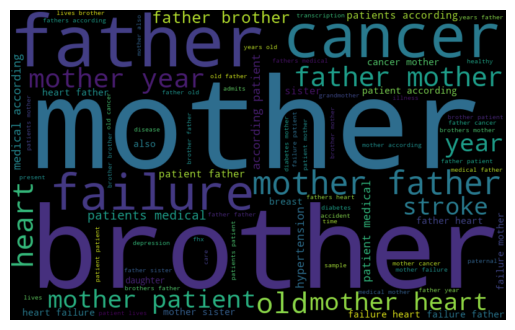

In [166]:
# Wordcloud for antecedents

wordcloud(df, antecedents_list)

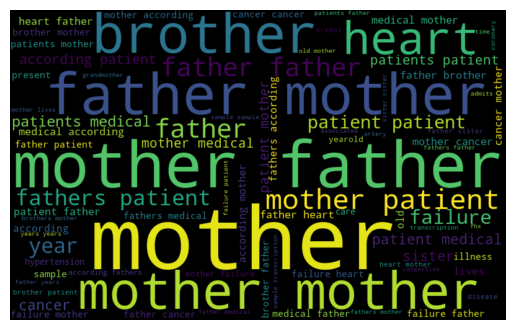

In [167]:
# Wordcloud for consequents

wordcloud(df, consequents_list)

In [168]:
# 3.4 

# Getting indexes of the antecedents and consequents from token data.

index_dict = {}
c_index_list = []
a_index_list = []

for sentence in range(len(token_data)):
    for i in antecedents:
        try:
            a_index = token_data[sentence].index(i[0])  
        except ValueError:
            a_index = -1
        a_index_list.append(a_index)
    for j in consequents:
        try:
            c_index = token_data[sentence].index(i[len(i)-1])
        except ValueError:
            c_index = -1
        c_index_list.append(c_index)


In [211]:
# Get the span from the user.

input_k = int(input("Enter k value between 5,7 or 10 "))
print(input_k)

Enter k value between 5,7 or 10 5
5


In [212]:
# Calculate the sentence span.

index_dict = {}
less_than_dict = {}

time1 = time.time()

for a in range(len(antecedents)):
    for i in range(len(token_data)):
        split_word = token_data[i].split()
        if ((antecedents[a][0] in token_data[i]) and (consequents[a][len(consequents[a])-1] in token_data[i]))!= False:
            
            a_index = -1
            c_index = -1
            
            # Get index of the antecedents and consequents in the actual sentences            
            for k, j in enumerate(token_data[i].split()):
                if (j == antecedents[a][0]):
                    a_index = k+1
                    break
            for k, j in enumerate(token_data[i].split()):
                if (j == consequents[a][len(consequents[a])-1]):
                    c_index = k+1
                    break
            
            # Check if the span is more than input. 
            if c_index >= 0 and a_index >= 0 and (c_index - a_index) > input_k:
                key = tuple([antecedents[a][0], consequents[a][len(consequents[a])-1]])
                if key in index_dict:
                    index_dict[key] += 1
                else:
                    index_dict[key] = 1
            elif c_index >= 0 and a_index >= 0 and (c_index - a_index) <= input_k:
                key = tuple([antecedents[a][0], consequents[a][len(consequents[a])-1]])
                if key in less_than_dict:
                    less_than_dict[key] += 1
                else:
                    less_than_dict[key] = 1
                
time2 = time.time()
print("Time taken = ", (time2-time1))
print(len(less_than_dict), less_than_dict)
                

Time taken =  69.73870372772217
810 {('family', 'history'): 14976, ('history', 'family'): 68040, ('history', 'mother'): 49390, ('mother', 'history'): 3818, ('mother', 'father'): 2914, ('father', 'mother'): 13797, ('family', 'mother'): 10350, ('mother', 'family'): 12528, ('history', 'father'): 15890, ('father', 'history'): 6958, ('father', 'family'): 9170, ('family', 'father'): 3696, ('died', 'father'): 18306, ('age', 'mother'): 22724, ('age', 'father'): 10600, ('died', 'mother'): 17302, ('father', 'died'): 5005, ('age', 'family'): 8580, ('brother', 'mother'): 7524, ('patient', 'history'): 6882, ('cancer', 'family'): 9920, ('age', 'history'): 3157, ('died', 'age'): 3636, ('age', 'died'): 2394, ('brother', 'father'): 1998, ('cancer', 'mother'): 14430, ('cancer', 'history'): 3680, ('brother', 'history'): 1428, ('patient', 'family'): 8463, ('died', 'family'): 9273, ('died', 'history'): 4960, ('cancer', 'father'): 7364, ('two', 'mother'): 20020, ('years', 'mother'): 462, ('one', 'father'): 

In [213]:
# Remove the sentences that have span more than k and frequency more than 60%.

sixty_percent = round((60 * len(token_data))/100)

new_dict = {}
less_dict = {}

for combination in index_dict:
    # Tokens to be removed
    if index_dict[combination] >= sixty_percent:
        new_dict[combination] = index_dict[combination]
    # Tokens to be kept
    else:
        less_dict[combination] = index_dict[combination]

print(len(new_dict), new_dict)
print("------------------------")
print(len(less_dict), less_dict)
    

139 {('history', 'family'): 6300, ('history', 'mother'): 42206, ('mother', 'history'): 874, ('mother', 'father'): 1645, ('father', 'mother'): 7446, ('family', 'mother'): 8694, ('mother', 'family'): 3480, ('history', 'father'): 18614, ('father', 'history'): 490, ('father', 'family'): 655, ('family', 'father'): 4704, ('died', 'father'): 2712, ('age', 'mother'): 3933, ('age', 'father'): 848, ('died', 'mother'): 5486, ('father', 'died'): 637, ('age', 'family'): 1540, ('brother', 'mother'): 1386, ('patient', 'history'): 2886, ('cancer', 'family'): 744, ('died', 'age'): 707, ('age', 'died'): 315, ('brother', 'father'): 216, ('cancer', 'mother'): 740, ('brother', 'history'): 210, ('patient', 'family'): 6851, ('died', 'family'): 1124, ('died', 'history'): 310, ('cancer', 'father'): 1052, ('two', 'mother'): 4620, ('mother', 'age'): 336, ('two', 'father'): 1900, ('history', 'died'): 1236, ('patient', 'mother'): 12604, ('father', 'age'): 1081, ('sample', 'transcription'): 825, ('disease', 'mother

In [214]:
# Creating a main list of all correct association patterns.

main_dict = {}
main_dict = less_than_dict.copy()

for key in less_dict:
    if key in main_dict:
        main_dict[key] += less_dict[key]
    else:
        main_dict[key] = less_dict[key]
        
print(len(main_dict), main_dict)


838 {('family', 'history'): 15104, ('history', 'family'): 68040, ('history', 'mother'): 49390, ('mother', 'history'): 3818, ('mother', 'father'): 2914, ('father', 'mother'): 13797, ('family', 'mother'): 10350, ('mother', 'family'): 12528, ('history', 'father'): 15890, ('father', 'history'): 6958, ('father', 'family'): 9170, ('family', 'father'): 3696, ('died', 'father'): 18306, ('age', 'mother'): 22724, ('age', 'father'): 10600, ('died', 'mother'): 17302, ('father', 'died'): 5005, ('age', 'family'): 8580, ('brother', 'mother'): 7524, ('patient', 'history'): 6882, ('cancer', 'family'): 9920, ('age', 'history'): 3311, ('died', 'age'): 3636, ('age', 'died'): 2394, ('brother', 'father'): 1998, ('cancer', 'mother'): 14430, ('cancer', 'history'): 3680, ('brother', 'history'): 1428, ('patient', 'family'): 8463, ('died', 'family'): 9273, ('died', 'history'): 4960, ('cancer', 'father'): 7364, ('two', 'mother'): 20020, ('years', 'mother'): 651, ('one', 'father'): 62, ('mother', 'age'): 518, ('br

In [215]:
# 3.5 

# Check for relative arrangement of the association patterns.

wordList = []
wordListDict = {}
dict_keys = list(main_dict.keys())

for words in dict_keys:
    for a in dict_keys:
        if ([str(words[1]), str(words[0])] == list(a)):
            key = words
            if not ((words in wordListDict) or (a in wordListDict)):
                wordListDict[key] = int(main_dict[key])
                wordListDict[key] += int(main_dict[a])
            wordList.append(words)
            
print(len(wordListDict), sorted(wordList))




258 [('abuse', 'alcohol'), ('abuse', 'father'), ('abuse', 'history'), ('abuse', 'mother'), ('according', 'care'), ('according', 'family'), ('according', 'history'), ('according', 'medical'), ('according', 'mother'), ('according', 'patient'), ('according', 'patients'), ('admits', 'associated'), ('admits', 'family'), ('admits', 'patient'), ('age', 'breast'), ('age', 'brother'), ('age', 'brothers'), ('age', 'cancer'), ('age', 'died'), ('age', 'family'), ('age', 'father'), ('age', 'fhx'), ('age', 'grandmother'), ('age', 'heart'), ('age', 'history'), ('age', 'lives'), ('age', 'medical'), ('age', 'mother'), ('age', 'old'), ('age', 'patient'), ('age', 'sample'), ('age', 'sisters'), ('age', 'time'), ('age', 'two'), ('age', 'years'), ('alcohol', 'abuse'), ('also', 'father'), ('also', 'history'), ('artery', 'coronary'), ('artery', 'disease'), ('artery', 'family'), ('artery', 'father'), ('artery', 'history'), ('associated', 'admits'), ('associated', 'family'), ('associated', 'history'), ('associa

In [216]:
# 3.6 

# Ordering the list by its frequency

dictionary_keys = list(wordListDict.keys())
sorted_dict = {dictionary_keys[i]: sorted(
    wordListDict.values())[i] for i in range(len(dictionary_keys))}

print(sorted_dict)

{('family', 'history'): 14, ('history', 'mother'): 16, ('mother', 'father'): 18, ('family', 'mother'): 20, ('history', 'father'): 21, ('father', 'family'): 22, ('died', 'father'): 24, ('age', 'mother'): 24, ('age', 'father'): 27, ('died', 'mother'): 28, ('age', 'family'): 28, ('brother', 'mother'): 30, ('patient', 'history'): 35, ('cancer', 'family'): 35, ('age', 'history'): 36, ('died', 'age'): 40, ('brother', 'father'): 40, ('cancer', 'mother'): 42, ('cancer', 'history'): 42, ('brother', 'history'): 42, ('patient', 'family'): 42, ('died', 'family'): 54, ('died', 'history'): 56, ('cancer', 'father'): 56, ('two', 'mother'): 56, ('years', 'mother'): 56, ('one', 'father'): 56, ('breast', 'cancer'): 64, ('cancer', 'age'): 64, ('two', 'father'): 64, ('one', 'mother'): 65, ('patient', 'mother'): 65, ('well', 'mother'): 66, ('diabetes', 'history'): 72, ('disease', 'history'): 72, ('sister', 'history'): 75, ('sample', 'transcription'): 78, ('disease', 'mother'): 80, ('years', 'father'): 80, (

In [217]:
# List of family members

family = ["mother", "mothers", "brother", "brothers", "grandfather", "grandfathers", "sister", "sisters", "grandmother", "grandmothers", "father", "fathers", "mom", "moms", "dad", "dads", "son", "sons", "daughter", "daughters", "uncle", "uncles", "aunt", "aunts", "niece", "nieces", "nephew", "nephews", "cousin", "cousins"]


In [218]:
# 3.6 (a)
# WordList that contains atleast one family member.

family_list = []
keys_list = list(wordListDict.keys())
for key in keys_list:
    for member in family:
        if member in key:
            family_list.append(key)
            
print(len(family_list), family_list)

113 [('history', 'mother'), ('mother', 'father'), ('mother', 'father'), ('family', 'mother'), ('history', 'father'), ('father', 'family'), ('died', 'father'), ('age', 'mother'), ('age', 'father'), ('died', 'mother'), ('brother', 'mother'), ('brother', 'mother'), ('brother', 'father'), ('brother', 'father'), ('cancer', 'mother'), ('brother', 'history'), ('cancer', 'father'), ('two', 'mother'), ('years', 'mother'), ('one', 'father'), ('two', 'father'), ('one', 'mother'), ('patient', 'mother'), ('well', 'mother'), ('sister', 'history'), ('disease', 'mother'), ('years', 'father'), ('fhx', 'mother'), ('heart', 'father'), ('age', 'brother'), ('sister', 'family'), ('fhx', 'father'), ('medical', 'mother'), ('grandmother', 'history'), ('old', 'mother'), ('lives', 'mother'), ('brother', 'died'), ('old', 'father'), ('grandmother', 'family'), ('heart', 'mother'), ('sisters', 'mother'), ('sisters', 'mother'), ('sisters', 'father'), ('sisters', 'father'), ('also', 'father'), ('brothers', 'family'), 

In [219]:
# List of diseases

diseases = ["breast", "cancer", "ADHD", "HTN", "bipolar", "hypertension", "CA", "bipolar", "brain aneurysm", "cancer", "depressed","cerebral", "aneurysm", "colon", "depression","cerebrovascular", "accident","gastric", "carcinoma","mental", "illness", "stroke","lung" ,"mood", "disorder", "strokes","prostate" ,"adult-onset", "diabetes","renal" "CA","nervous", "breakdowns", "throat", "Schizophrenia", "mellitus", "CHF", "suicide", "DM", "CAD","coronary", "heart", "disease","type", "coronary"  ,"acute", "myocardial", "infarction", "attack","alcohol", "abuse","congestive", "failure", "alcoholic","artery" , "alcoholism",  "valvular", "MI",  "use","vascular" ,"drug", "addict", "substance" ]


In [220]:
# 3.6 (b)
# WordList that contains atleast one disease.

disease_list = []
for key in keys_list:
    for member in diseases:
        if member in key:
            disease_list.append(key)
print(len(disease_list), disease_list)

89 [('cancer', 'family'), ('cancer', 'family'), ('cancer', 'mother'), ('cancer', 'mother'), ('cancer', 'history'), ('cancer', 'history'), ('cancer', 'father'), ('cancer', 'father'), ('breast', 'cancer'), ('breast', 'cancer'), ('breast', 'cancer'), ('cancer', 'age'), ('cancer', 'age'), ('diabetes', 'history'), ('disease', 'history'), ('disease', 'mother'), ('cancer', 'died'), ('cancer', 'died'), ('disease', 'family'), ('heart', 'father'), ('illness', 'history'), ('heart', 'history'), ('heart', 'family'), ('stroke', 'died'), ('hypertension', 'family'), ('heart', 'mother'), ('breast', 'history'), ('illness', 'present'), ('cancer', 'brother'), ('cancer', 'brother'), ('hypertension', 'father'), ('hypertension', 'mother'), ('heart', 'died'), ('heart', 'age'), ('heart', 'brother'), ('failure', 'died'), ('heart', 'failure'), ('heart', 'failure'), ('coronary', 'artery'), ('coronary', 'artery'), ('coronary', 'artery'), ('coronary', 'disease'), ('coronary', 'disease'), ('coronary', 'disease'), ('

In [221]:
# Function to check if disease is present

def isDiseasePresent(key):
    isPresent = False
    for disease in diseases:
        if disease in key:
            isPresent = True
            break
        else:
            isPresent = False
    return isPresent

In [222]:
# Function to check if family member is present

def isFamilyPresent(key):
    isPresent = False
    for member in family:
        if member in key:
            isPresent = True
            break
        else:
            isPresent = False
    return isPresent

In [223]:
# 3.6 (c)
# WordList that contains atleast one family member but no disease.

familyNoDisease = []
keys_list = list(wordListDict.keys())

for key in keys_list:
    for member in family:
        isPresent = isDiseasePresent(key)
        if member in key and (not isPresent):
            familyNoDisease.append(key)

print(len(familyNoDisease), familyNoDisease)
            


96 [('history', 'mother'), ('mother', 'father'), ('mother', 'father'), ('family', 'mother'), ('history', 'father'), ('father', 'family'), ('died', 'father'), ('age', 'mother'), ('age', 'father'), ('died', 'mother'), ('brother', 'mother'), ('brother', 'mother'), ('brother', 'father'), ('brother', 'father'), ('brother', 'history'), ('two', 'mother'), ('years', 'mother'), ('one', 'father'), ('two', 'father'), ('one', 'mother'), ('patient', 'mother'), ('well', 'mother'), ('sister', 'history'), ('years', 'father'), ('fhx', 'mother'), ('age', 'brother'), ('sister', 'family'), ('fhx', 'father'), ('medical', 'mother'), ('grandmother', 'history'), ('old', 'mother'), ('lives', 'mother'), ('brother', 'died'), ('old', 'father'), ('grandmother', 'family'), ('sisters', 'mother'), ('sisters', 'mother'), ('sisters', 'father'), ('sisters', 'father'), ('also', 'father'), ('brothers', 'family'), ('grandmother', 'mother'), ('grandmother', 'mother'), ('sister', 'mother'), ('sister', 'mother'), ('brother', 

In [224]:
# 3.6 (d)
# WordList that contains both a family member and a disease.

familyDisease = []
keys_list = list(wordListDict.keys())

for key in keys_list:
    for member in family:
        isPresent = isDiseasePresent(key)
        if member in key:
            for disease in diseases:
                if disease in key:
                    familyDisease.append(key)

print(len(familyDisease), familyDisease)
            


21 [('cancer', 'mother'), ('cancer', 'mother'), ('cancer', 'father'), ('cancer', 'father'), ('disease', 'mother'), ('heart', 'father'), ('heart', 'mother'), ('cancer', 'brother'), ('cancer', 'brother'), ('hypertension', 'father'), ('hypertension', 'mother'), ('heart', 'brother'), ('failure', 'father'), ('depression', 'father'), ('congestive', 'father'), ('abuse', 'mother'), ('diabetes', 'daughter'), ('artery', 'father'), ('coronary', 'father'), ('coronary', 'father'), ('abuse', 'father')]


In [225]:
# 3.6 (e)
# WordList that contains neither a family nor a disease.
noFamilyNoDisease = []
keys_list = list(wordListDict.keys())

for key in keys_list:
    if (not isDiseasePresent(key)) and (not isFamilyPresent(key)):
        noFamilyNoDisease.append(key)
        
print(len(noFamilyNoDisease), noFamilyNoDisease)


113 [('family', 'history'), ('age', 'family'), ('patient', 'history'), ('age', 'history'), ('died', 'age'), ('patient', 'family'), ('died', 'family'), ('died', 'history'), ('sample', 'transcription'), ('one', 'family'), ('two', 'family'), ('present', 'history'), ('two', 'history'), ('admits', 'family'), ('years', 'family'), ('years', 'old'), ('years', 'age'), ('also', 'history'), ('social', 'history'), ('associated', 'admits'), ('admits', 'patient'), ('associated', 'history'), ('associated', 'family'), ('medical', 'history'), ('fhx', 'age'), ('patients', 'family'), ('medical', 'family'), ('medical', 'transcription'), ('medical', 'sample'), ('patients', 'history'), ('two', 'died'), ('well', 'history'), ('states', 'history'), ('associated', 'patient'), ('care', 'patient'), ('old', 'died'), ('old', 'age'), ('lives', 'patient'), ('sample', 'patient'), ('two', 'age'), ('transcription', 'patient'), ('reportsubjective', 'sample'), ('care', 'history'), ('old', 'family'), ('description', 'sampl

In [226]:
# 3.6 (g) 
# Common characteristics observed in its top 20 frequent wordLists

# Mother seems to be the most frequent in all the family members. 
# Followed by father, brother and sister .
# Least common family member seem to be grandmother, son and daughter.

# This means that most of the diseases seem to be inherited from mother and father. 


In [227]:
# Check wordLists containing mother 

family_list = []
keys_list = list(wordListDict.keys())
for key in keys_list:
    if "mother" in key or "mom" in key:
        family_list.append(key)
        
print(len(family_list), family_list)

35 [('history', 'mother'), ('mother', 'father'), ('family', 'mother'), ('age', 'mother'), ('died', 'mother'), ('brother', 'mother'), ('cancer', 'mother'), ('two', 'mother'), ('years', 'mother'), ('one', 'mother'), ('patient', 'mother'), ('well', 'mother'), ('disease', 'mother'), ('fhx', 'mother'), ('medical', 'mother'), ('old', 'mother'), ('lives', 'mother'), ('heart', 'mother'), ('sisters', 'mother'), ('grandmother', 'mother'), ('hypertension', 'mother'), ('sister', 'mother'), ('brothers', 'mother'), ('patients', 'mother'), ('yearold', 'mother'), ('mom', 'sample'), ('fathers', 'mother'), ('associated', 'mother'), ('according', 'mother'), ('patient', 'mom'), ('medical', 'mom'), ('abuse', 'mother'), ('grandfather', 'mother'), ('transcription', 'mother'), ('mother', 'name')]


In [228]:
# Check wordLists containing father 

family_list = []
keys_list = list(wordListDict.keys())
for key in keys_list:
    if "father" in key or "fathers" in key:
        family_list.append(key)
        
print(len(family_list), family_list)

32 [('mother', 'father'), ('history', 'father'), ('father', 'family'), ('died', 'father'), ('age', 'father'), ('brother', 'father'), ('cancer', 'father'), ('one', 'father'), ('two', 'father'), ('years', 'father'), ('heart', 'father'), ('fhx', 'father'), ('old', 'father'), ('sisters', 'father'), ('also', 'father'), ('hypertension', 'father'), ('brothers', 'father'), ('fathers', 'family'), ('fathers', 'mother'), ('fathers', 'history'), ('failure', 'father'), ('grandmother', 'father'), ('depression', 'father'), ('father', 'daughter'), ('fathers', 'years'), ('patients', 'fathers'), ('congestive', 'father'), ('fathers', 'brother'), ('medical', 'fathers'), ('artery', 'father'), ('coronary', 'father'), ('abuse', 'father')]


In [229]:
# 3.7 
# WordList that contains atleast one disease but no family member.

noFamilyDisease = []
keys_list = list(wordListDict.keys())

for key in keys_list:
    for member in diseases:
        isPresent = isFamilyPresent(key)
        if member in key and (not isPresent):
            noFamilyDisease.append(key)

print(len(noFamilyDisease), noFamilyDisease)

68 [('cancer', 'family'), ('cancer', 'family'), ('cancer', 'history'), ('cancer', 'history'), ('breast', 'cancer'), ('breast', 'cancer'), ('breast', 'cancer'), ('cancer', 'age'), ('cancer', 'age'), ('diabetes', 'history'), ('disease', 'history'), ('cancer', 'died'), ('cancer', 'died'), ('disease', 'family'), ('illness', 'history'), ('heart', 'history'), ('heart', 'family'), ('stroke', 'died'), ('hypertension', 'family'), ('breast', 'history'), ('illness', 'present'), ('heart', 'died'), ('heart', 'age'), ('failure', 'died'), ('heart', 'failure'), ('heart', 'failure'), ('coronary', 'artery'), ('coronary', 'artery'), ('coronary', 'artery'), ('coronary', 'disease'), ('coronary', 'disease'), ('coronary', 'disease'), ('illness', 'yearold'), ('breast', 'age'), ('artery', 'disease'), ('artery', 'disease'), ('white', 'illness'), ('failure', 'family'), ('type', 'sample'), ('failure', 'history'), ('name', 'type'), ('old', 'cancer'), ('old', 'cancer'), ('two', 'cancer'), ('two', 'cancer'), ('disea

In [230]:
# The disease cancer seems to be most frequent, specifically breast cancer.
# Followed by heart attack, coronary heart disease, coronary artery disease
# Hypertension, congestive heart failure and diabetes (usual as well as type 2) seem to be least common

disease_list = []
keys_list = list(wordListDict.keys())
for key in keys_list:
    if "cancer" in key:
        disease_list.append(key)
        
print(len(disease_list), disease_list)

10 [('cancer', 'family'), ('cancer', 'mother'), ('cancer', 'history'), ('cancer', 'father'), ('breast', 'cancer'), ('cancer', 'age'), ('cancer', 'died'), ('cancer', 'brother'), ('old', 'cancer'), ('two', 'cancer')]


In [231]:
# 3.8

# IMPORTANT: The potential solution to identify family history information of a patient in the format: 
# (family member, disease). 

# (Mother, Father, Brother	Cancer)
# (Mother	Breast Cancer)
# (Mother, Father	Hypertension)
# (Father, Mother	Coronary artery disease)
# (Father, Mother	Heart attack)
# (Brother	Heart disease)
# (Father	Heart failure)
# (Mother, Father	Depression)
# (Father	Congestive heart failure)
# (Mother, Father	Alchohol abuse)
# (Mother, Grandmother	Diabetes)
# (Father	Coronary heart disease)

# From the above list, it seems that cancer is the most indicative of a heriditary nature. 
# There seems to be the maximum correlation between cancer and father, mother and brother.
# Breast cancer, especially, is related to mother. 
# Hypertension is also correlated with mother and father. 
# Diabeters seems to be more related to mother and grandmother.
# Heart diseases, coronary heart disease, coronary artery disease seem to be related to father. 
# Alchohol abuse and alchoholism along with mental illnesses seem to be inherited from mother and father. 

# Pros: There is clear correlation between aforementioned diseases and the 
#       family members mentioned. 

# Cons: The correlation can only be found for the most commonly found diseases. 
#       There isn't much data available for all the diseases to find a clear correlation. 
#       More data is needed for finding association patterns for all diseases. 

